DATA SPLITTING

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Start fresh - reload and split your data properly
df = pd.read_csv('D:\\NNDL\\data\\reduced_data.csv')
X = df.drop('CREDIT_SCORE', axis=1)
y = df['CREDIT_SCORE']

# Split without any filtering
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify shapes match
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_test shape: {y_test.shape}")

# They should match: (800, 55) and (800,) for training, (200, 55) and (200,) for test


X_train_scaled shape: (800, 55)
y_train shape: (800,)
X_test_scaled shape: (200, 55)
y_test shape: (200,)


In [39]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

# Random Forest (excellent for tabular data)
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)

print(f"Random Forest Results:")
print(f"R² Score: {rf_r2:.4f}")
print(f"MAE: {rf_mae:.2f}")
print(f"MSE: {rf_mse:.2f}")

# XGBoost (industry standard for credit scoring)
print("\nTraining XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_mse = mean_squared_error(y_test, xgb_pred)

print(f"XGBoost Results:")
print(f"R² Score: {xgb_r2:.4f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"MSE: {xgb_mse:.2f}")


Training Random Forest...
Random Forest Results:
R² Score: 0.7631
MAE: 23.11
MSE: 940.28

Training XGBoost...
XGBoost Results:
R² Score: 0.7308
MAE: 23.74
MSE: 1068.60


In [40]:
# Data quality analysis
print("=== DATA QUALITY ANALYSIS ===")
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Target variable analysis
print(f"\n=== TARGET VARIABLE ANALYSIS ===")
print(f"Credit Score Range: {y.min()} - {y.max()}")
print(f"Credit Score Mean: {y.mean():.2f}")
print(f"Credit Score Std: {y.std():.2f}")

# Check for outliers
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
outliers = y[(y < Q1 - 1.5*IQR) | (y > Q3 + 1.5*IQR)]
print(f"Number of outliers: {len(outliers)}")

# Feature correlation with target
correlations = X.corrwith(y).abs().sort_values(ascending=False)
print(f"\n=== TOP 10 FEATURES CORRELATED WITH CREDIT SCORE ===")
print(correlations.head(10))


=== DATA QUALITY ANALYSIS ===
Dataset shape: (1000, 56)
Missing values: 0
Duplicate rows: 0

=== TARGET VARIABLE ANALYSIS ===
Credit Score Range: 300 - 800
Credit Score Mean: 586.71
Credit Score Std: 63.41
Number of outliers: 34

=== TOP 10 FEATURES CORRELATED WITH CREDIT SCORE ===
R_DEBT_INCOME           0.857900
R_DEBT_SAVINGS          0.454068
DEFAULT                 0.333092
DEBT                    0.327231
R_EXPENDITURE_DEBT      0.307594
R_GROCERIES_DEBT        0.286999
R_ENTERTAINMENT_DEBT    0.279926
R_HEALTH_DEBT           0.259609
R_SAVINGS_INCOME        0.248420
R_TRAVEL_DEBT           0.229710
dtype: float64


TRYING MLP WITH PROCESSS
# MLP WITH PROCESSS

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Set random seeds for reproducibility
tf.random.set_seed(42)

# Advanced MLP with BatchNormalization and better architecture
def create_advanced_mlp(input_dim, learning_rate=0.001):
    model = Sequential([
        # Input layer with normalization
        Dense(512, input_shape=(input_dim,)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.4),
        
        # Hidden layers with residual-like connections
        Dense(256),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.3),
        
        Dense(128),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.2),
        
        Dense(64),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.1),
        
        # Output layer
        Dense(1)
    ])
    
    # Use advanced optimizer
    optimizer = Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    model.compile(
        optimizer=optimizer,
        loss='huber',  # More robust to outliers than MSE
        metrics=['mae']
    )
    
    return model

# Create the enhanced model
enhanced_mlp = create_advanced_mlp(X_train_scaled.shape[1])
enhanced_mlp.summary()


d:\NNDL\venv-name\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_97 (Dense)                │ (None, 512)            │        28,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,057 (801.00 KB)

 Trainable params: 203,137 (793.50 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import math

# Learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    elif epoch < 20:
        return initial_lr * 0.5
    elif epoch < 30:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

# Advanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    LearningRateScheduler(lr_schedule, verbose=1)
]

# Train with enhanced settings
history_enhanced = enhanced_mlp.fit(
    X_train_scaled, y_train,
    batch_size=16,  # Smaller batch size for better gradients
    epochs=150,
    validation_data=(X_test_scaled, y_test),
    callbacks=callbacks,
    verbose=1
)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 586.5033 - mae: 587.0033 - val_loss: 582.5689 - val_mae: 583.0689 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 584.6962 - mae: 585.1962 - val_loss: 581.1761 - val_mae: 581.6761 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 582.7372 - mae: 583.2372 - val_loss: 579.3403 - val_mae: 579.8403 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 580.4295 - mae: 580.9295 - val_loss: 576.2411 - val_mae: 576.7411 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 577.6663 - mae: 578.1663 

In [43]:
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer

def create_nn_friendly_features(X_train, X_test, y_train):
    """Create features optimized for neural networks"""
    
    # 1. Quantile transformation (makes distributions more normal)
    quantile_transformer = QuantileTransformer(n_quantiles=100, random_state=42)
    X_train_quantile = quantile_transformer.fit_transform(X_train)
    X_test_quantile = quantile_transformer.transform(X_test)
    
    # 2. Polynomial features (2nd degree interactions)
    poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    
    # Select top correlated features first to avoid explosion
    correlations = pd.DataFrame(X_train).corrwith(pd.Series(y_train)).abs()
    top_features = correlations.nlargest(10).index
    
    X_train_top = X_train[:, top_features]
    X_test_top = X_test[:, top_features]
    
    X_train_poly = poly_features.fit_transform(X_train_top)
    X_test_poly = poly_features.transform(X_test_top)
    
    # 3. Combine original quantile + polynomial features
    X_train_enhanced = np.concatenate([X_train_quantile, X_train_poly], axis=1)
    X_test_enhanced = np.concatenate([X_test_quantile, X_test_poly], axis=1)
    
    # 4. Final scaling
    final_scaler = StandardScaler()
    X_train_final = final_scaler.fit_transform(X_train_enhanced)
    X_test_final = final_scaler.transform(X_test_enhanced)
    
    return X_train_final, X_test_final, final_scaler

# Apply enhanced feature engineering
X_train_nn, X_test_nn, nn_scaler = create_nn_friendly_features(
    X_train_scaled, X_test_scaled, y_train
)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Enhanced NN features: {X_train_nn.shape[1]}")


Original features: 55
Enhanced NN features: 110


In [44]:
from sklearn.metrics import r2_score, mean_absolute_error

def create_mlp_ensemble(input_dim, n_models=5):
    """Create ensemble of different MLP architectures"""
    models = []
    
    # Different architectures for diversity
    architectures = [
        [512, 256, 128, 64],
        [256, 128, 64, 32],
        [768, 384, 192, 96],
        [400, 200, 100, 50],
        [600, 300, 150, 75]
    ]
    
    for i, arch in enumerate(architectures):
        model = Sequential([Dense(arch[0], activation='relu', input_shape=(input_dim,))])
        
        for units in arch[1:]:
            model.add(BatchNormalization())
            model.add(Dropout(0.3))
            model.add(Dense(units, activation='relu'))
        
        model.add(Dropout(0.2))
        model.add(Dense(1))
        
        model.compile(
            optimizer=Adam(learning_rate=0.001 * (0.5 ** i)),  # Different learning rates
            loss='huber',
            metrics=['mae']
        )
        
        models.append(model)
    
    return models

# Train ensemble
ensemble_models = create_mlp_ensemble(X_train_nn.shape[1])
ensemble_predictions = []

print("Training MLP Ensemble...")
for i, model in enumerate(ensemble_models):
    print(f"Training Model {i+1}/5...")
    
    model.fit(
        X_train_nn, y_train,
        batch_size=16,
        epochs=100,
        validation_data=(X_test_nn, y_test),
        callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
        verbose=0
    )
    
    pred = model.predict(X_test_nn, verbose=0).flatten()
    ensemble_predictions.append(pred)

# Ensemble prediction (average)
ensemble_pred = np.mean(ensemble_predictions, axis=0)
ensemble_r2 = r2_score(y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)

print(f"\nEnsemble Results:")
print(f"R² Score: {ensemble_r2:.4f}")
print(f"MAE: {ensemble_mae:.2f}")


d:\NNDL\venv-name\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training MLP Ensemble...
Training Model 1/5...
Training Model 2/5...
Training Model 3/5...
Training Model 4/5...
Training Model 5/5...

Ensemble Results:
R² Score: -0.8082
MAE: 57.68


In [45]:
# Install if not already: pip install keras-tuner
import keras_tuner as kt

def build_tunable_model(hp):
    model = Sequential()
    
    # Tune the number of layers and units
    model.add(Dense(
        units=hp.Int('units_1', min_value=64, max_value=512, step=64),
        activation='relu',
        input_shape=(X_train_nn.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    
    # Variable number of hidden layers
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(Dense(
            units=hp.Int(f'units_{i+2}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i+2}', 0.1, 0.4, step=0.1)))
    
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='huber',
        metrics=['mae']
    )
    
    return model

# Hyperparameter tuning (run this if you have time)
tuner = kt.RandomSearch(
    build_tunable_model,
    objective='val_loss',
    max_trials=20,
    directory='mlp_tuning',
    project_name='credit_scoring'
)

# Uncomment to run tuning (takes time)
# tuner.search(X_train_nn, y_train, epochs=50, validation_data=(X_test_nn, y_test))
# best_model = tuner.get_best_models(num_models=1)[0]


d:\NNDL\venv-name\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# Combine all improvements into final model
final_mlp = Sequential([
    Dense(512, input_shape=(X_train_nn.shape[1],)),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.4),
    
    Dense(256),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.3),
    
    Dense(128),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.2),
    
    Dense(64),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),
    
    Dense(1)
])

final_mlp.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='huber',
    metrics=['mae']
)

# Train final model
final_history = final_mlp.fit(
    X_train_nn, y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_test_nn, y_test),
    callbacks=[
        EarlyStopping(patience=25, restore_best_weights=True),
        ReduceLROnPlateau(patience=10, factor=0.5)
    ],
    verbose=1
)

# Final evaluation
final_pred = final_mlp.predict(X_test_nn, verbose=0).flatten()
final_r2 = r2_score(y_test, final_pred)
final_mae = mean_absolute_error(y_test, final_pred)

print(f"\nFINAL ENHANCED MLP RESULTS:")
print(f"R² Score: {final_r2:.4f}")
print(f"MAE: {final_mae:.2f}")
print(f"Improvement over original: {final_r2 - 0.2731:.4f} R² points")


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 586.2441 - mae: 586.7441 - val_loss: 582.5222 - val_mae: 583.0222 - learning_rate: 5.0000e-04
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 585.3385 - mae: 585.8385 - val_loss: 582.0944 - val_mae: 582.5944 - learning_rate: 5.0000e-04
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 584.4344 - mae: 584.9344 - val_loss: 581.4377 - val_mae: 581.9377 - learning_rate: 5.0000e-04
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 583.4456 - mae: 583.9456 - val_loss: 580.6287 - val_mae: 581.1287 - learning_rate: 5.0000e-04
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 582.4099 - mae: 582.9099 - val_loss: 579.7955 - val_mae: 580.2955 - learning_rate: 5.0000e-04
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 581.2507 - mae: 581.7507 - val_loss: 578.6146 - val_mae: 579.1146 - learning_rate: 5.0000e-04
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 579.9877 - mae: 580.487

Creating SHAP explainer with enhanced features...


C:\Users\Albin\AppData\Local\Temp\ipykernel_784\3216362181.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


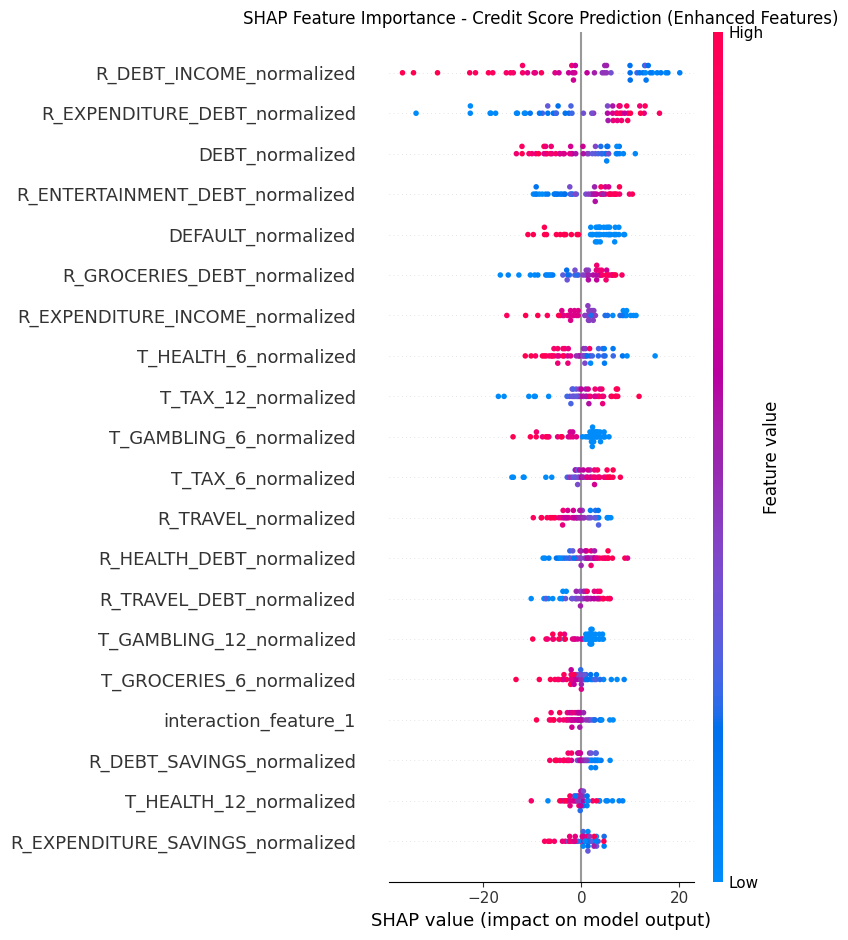

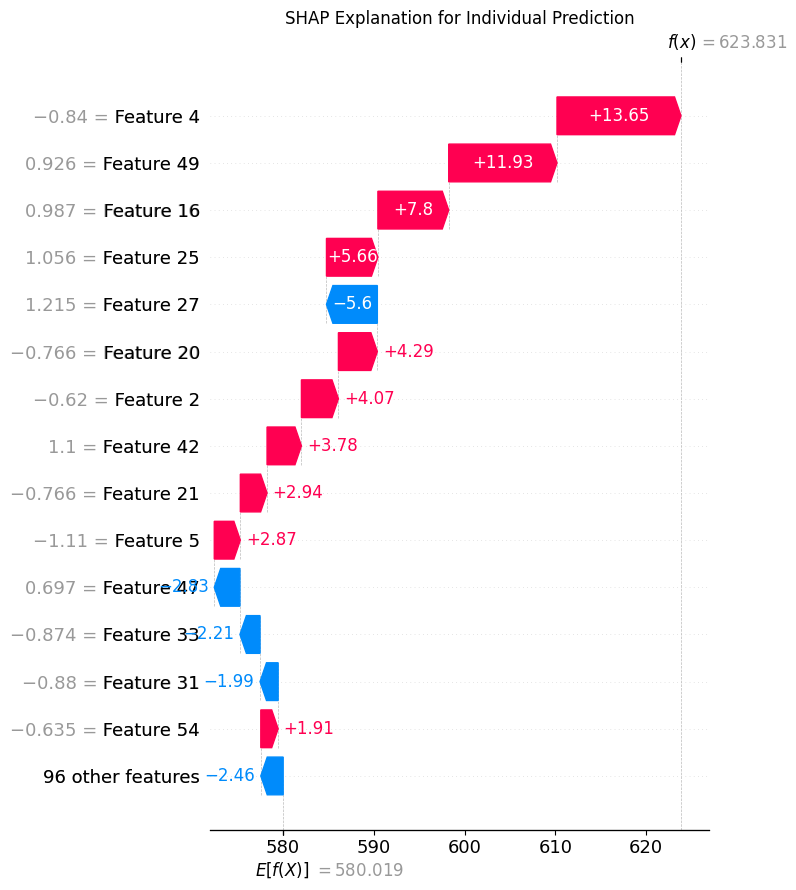

In [52]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Create feature names for enhanced data
def create_enhanced_feature_names(original_features, enhanced_shape):
    """Create interpretable names for enhanced features"""
    feature_names = []
    
    # First 55: Quantile-transformed original features
    for col in original_features:
        feature_names.append(f"{col}_normalized")
    
    # Remaining: Polynomial interaction features
    remaining_features = enhanced_shape - len(original_features)
    for i in range(remaining_features):
        feature_names.append(f"interaction_feature_{i+1}")
    
    return feature_names

# Create proper feature names
enhanced_feature_names = create_enhanced_feature_names(X.columns, X_train_nn.shape[1])

# Create SHAP explainer with enhanced data
print("Creating SHAP explainer with enhanced features...")
explainer = shap.Explainer(final_mlp, X_train_nn)
shap_values = explainer(X_test_nn[:50])  # Use fewer samples for speed

# Feature importance summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values, 
    X_test_nn[:50], 
    feature_names=enhanced_feature_names,
    max_display=20,  # Show top 20 features only
    show=False
)
plt.title("SHAP Feature Importance - Credit Score Prediction (Enhanced Features)")
plt.tight_layout()
plt.show()

# Individual prediction explanation
plt.figure(figsize=(10, 6))
shap.waterfall_plot(shap_values[0], max_display=15, show=False)
plt.title("SHAP Explanation for Individual Prediction")
plt.tight_layout()
plt.show()


#What it shows:
The SHAP summary plot displays the impact of each feature on the model’s predictions for credit score. Each dot represents a SHAP value for a feature in a single sample.
How to read:
Features at the top are the most important for the model’s predictions.
The color shows the feature value (red = high, blue = low).
The horizontal position shows whether the feature increases (right) or decreases (left) the predicted credit score.
Interpretation:
If a feature’s red dots are mostly to the right, high values of that feature increase the credit score.
If blue dots are to the left, low values decrease the score.
Features with a wide spread have a strong influence; those with a narrow spread have less impact.

SHAP Waterfall Plot (Individual Prediction Explanation)
What it shows:
The waterfall plot explains how each feature contributed to a single prediction.
How to read:
The plot starts at the model’s expected value (average prediction).
Each bar shows how a feature pushes the prediction up or down.
The final value is the model’s prediction for that sample.
Interpretation:
Features with large bars have the most influence on this specific prediction.
Positive bars increase the predicted credit score; negative bars decrease it.
You can see exactly which features made the model predict higher or lower for this individual.

In [55]:
# Save your trained model
final_mlp.save('models/credit_score_mlp_model.h5')

# Save the scaler too
import joblib
joblib.dump(nn_scaler, 'models/feature_scaler.pkl')

# Test loading (to verify it works)
from tensorflow.keras.models import load_model
loaded_model = load_model('models/credit_score_mlp_model.h5')
loaded_scaler = joblib.load('models/feature_scaler.pkl')


Step 3: Create Prediction Pipeline
What this means: Build a complete function that takes raw customer data and returns credit score prediction.

SAVING ALL TRANSFORMERS 


In [57]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures, StandardScaler
import joblib

# Save transformers that were created during training
def save_training_artifacts():
    """Save all transformers created during training"""
    
    # Recreate the transformers from your training process
    # 1. Quantile transformer
    quantile_transformer = QuantileTransformer(n_quantiles=100, random_state=42)
    X_train_quantile = quantile_transformer.fit_transform(X_train_scaled)
    
    # 2. Get top features (same as training)
    correlations = pd.DataFrame(X_train_scaled, columns=X.columns).corrwith(pd.Series(y_train)).abs()
    top_features = correlations.nlargest(10).index
    top_feature_indices = [X.columns.get_loc(col) for col in top_features]
    
    # 3. Polynomial features
    poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_train_top = X_train_scaled[:, top_feature_indices]
    X_train_poly = poly_features.fit_transform(X_train_top)
    
    # 4. Combine features
    X_train_enhanced = np.concatenate([X_train_quantile, X_train_poly], axis=1)
    
    # 5. Final scaler
    final_scaler = StandardScaler()
    final_scaler.fit(X_train_enhanced)
    
    # Save all transformers
    joblib.dump(quantile_transformer, 'models/quantile_transformer.pkl')
    joblib.dump(poly_features, 'models/poly_features.pkl')
    joblib.dump(final_scaler, 'models/final_scaler.pkl')
    joblib.dump(top_feature_indices, 'models/top_feature_indices.pkl')
    joblib.dump(list(X.columns), 'models/feature_names.pkl')
    
    print("All transformers saved successfully!")

# Run this once to save transformers
save_training_artifacts()


All transformers saved successfully!
